In [766]:
import numpy as np
from koopman.simulation.simulator import rk4_step, simulate
from koopman.simulation.systems import Pendulum
import matplotlib.pyplot as plt
from scipy.linalg import expm
from spatialmath.base import *

import jax
import jax.numpy as jnp
from jax import jacfwd, vmap
import optax

pendulum = Pendulum(Pendulum.Params())

In [767]:
def pendulum_dynamics(x, u):
    theta, omega = x
    theta_dot = jnp.array([omega])
    omega_dot = -pendulum.params.g / pendulum.params.l * jnp.sin(theta) - pendulum.params.b * omega + u
    
    return jnp.array([theta_dot, omega_dot]).squeeze()

Jx = jax.jacfwd(pendulum_dynamics, argnums=0)
Ju = jax.jacfwd(pendulum_dynamics, argnums=1)

B_nom = jnp.array([[0.0], [1 / (pendulum.params.m * pendulum.params.l**2)]])

In [822]:
def build_liftings(order):
    def phi(x):
        nx = x.shape[0]
        # x = scale_x(x)
        K = order
        
        θ, ω = x
        obs = [θ, ω]

        # 2) Fourier in θ
        for k in range(1, K+1):
            obs += [jnp.sin(k*θ), jnp.cos(k*θ)]
            obs += [ω*jnp.sin(k*θ), ω*jnp.cos(k*θ)]
            obs += [ω**2 * jnp.sin(k*θ), ω**2 * jnp.cos(k*θ)]
        
        # 4) energy invariant
        H = 1/2 * ω**2 + pendulum.params.g * (1 - jnp.cos(θ))
        obs.append(H)
        
        return jnp.stack(obs)
        
    phi_jac = jacfwd(phi)
    
    def phi_dot(x, xdot):        
        J = phi_jac(x)         # shape (nz, nx)
        return J @ xdot        # shape (nz,)

    batch_phi = vmap(phi)
    batch_phi_dot = vmap(phi_dot)
    batch_phi_jac = vmap(phi_jac)
    
    return batch_phi, batch_phi_dot, phi_jac

# def build_rbf_liftings(low, high, num_centers_per_dim, bandwidth):
#     """
#     Build lifting functions where phi(x) is a vector of RBF activations:
#         phi_i(x) = exp(-0.5 * ||x - c_i||^2 / sigma^2)
#     for centers c_i placed on a regular grid in [low, high].

#     Args:
#         low: array, shape (n_x,), minimum of each state dimension
#         high: array, shape (n_x,), maximum of each state dimension
#         num_centers_per_dim: sequence of ints, length n_x,
#             how many RBF centers along each axis
#         bandwidth: float or array of shape (n_x,),
#             the σ in the Gaussian: larger → smoother, more overlap

#     Returns:
#         batch_phi:    (X → Φ)   maps (B, n_x) → (B, n_z)
#         batch_phi_dot:(X, Ẋ → Φ̇) maps (B, n_x), (B, n_x) → (B, n_z)
#         batch_phi_jac:(X → dΦ/dX) maps (B, n_x) → (B, n_z, n_x)
#         centers:      array, shape (n_z, n_x)
#     """
#     low = jnp.array(low)
#     high = jnp.array(high)
#     nx = low.shape[0]

#     # build a meshgrid of centers
#     grids = [jnp.linspace(low[i], high[i], num_centers_per_dim[i])
#              for i in range(nx)]
#     mesh = jnp.meshgrid(*grids, indexing='ij')
#     centers = jnp.stack([m.flatten() for m in mesh], axis=1)  # (n_z, n_x)
#     n_z = centers.shape[0]

#     # allow scalar or per-dim bandwidth
#     bw = jnp.array(bandwidth)
#     def phi(x):
#         # x: (n_x,)
#         diff = (x - centers) / bw        # broadcast to (n_z, n_x)
#         rbfs = jnp.exp(-0.5 * jnp.sum(diff**2, axis=1))  # (n_z,)
        
#         return jnp.concatenate([x, rbfs], axis=-1)

#     phi_jac = jacfwd(phi)
    
#     def phi_dot(x, xdot):
#         J = phi_jac(x)     # (n_z, n_x)
#         return J @ xdot    # (n_z,)

#     batch_phi     = vmap(phi)     # maps (B, n_x) -> (B, n_z)
#     batch_phi_dot = vmap(phi_dot) # maps (B, n_x),(B, n_x) -> (B, n_z)
#     batch_phi_jac = vmap(phi_jac) # maps (B, n_x) -> (B, n_z, n_x)

#     return batch_phi, batch_phi_dot, batch_phi_jac, centers

def koopman_Y(phi, u):
    u_z_kron = jnp.kron(u, phi)
    return jnp.concat([phi, u, u_z_kron], axis=-1)
    
batch_koopman_Y = vmap(koopman_Y)

In [823]:
def build_koopman_loss_fn(Y, phi_dot, observable_weights=None, l1_weight=0.0):
    B, nz = phi_dot.shape
    _, ny = Y.shape
    
    if observable_weights is None:
        observable_weights = jnp.ones(nz)
    else:
        observable_weights = observable_weights

    def loss_fn(A_flat):
        A = A_flat.reshape(nz, ny)

        pred_phi_dot = Y @ A.T                  # shape (B, nz)
        error = phi_dot - pred_phi_dot            # shape (B, nz)
        weighted_error_sq = error**2 * observable_weights
        mse_loss = jnp.mean(jnp.sum(weighted_error_sq, axis=1))

        l1_reg = l1_weight * jnp.sum(jnp.abs(A))

        return mse_loss + l1_reg

    return loss_fn

def train_koopman_optax(Y, phi_dot, lr=1e-2, steps=1000, observable_weights=None, l1_weight=0.0):
    B, nz = phi_dot.shape
    _, ny = Y.shape
    
    A_init = jnp.zeros((nz, ny))
    A_flat = A_init.flatten()

    loss_fn = build_koopman_loss_fn(Y, phi_dot, observable_weights, l1_weight)
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(A_flat)

    @jax.jit
    def step(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    losses = []

    for _ in range(steps):
        A_flat, opt_state, loss = step(A_flat, opt_state)
        if _ % 1000 == 0:
            print(f"Iter {_} / {steps}: loss = {loss}")
        losses.append(loss)

    A_opt = A_flat.reshape(nz, ny)
    return A_opt, losses

In [824]:
low = jnp.array([-np.pi, -3.0])
high = jnp.array([np.pi, 3.0])

N = 300_000

thetas = np.random.uniform(low[0], high[0], N)
omegas = np.random.uniform(low[1], high[1], N)

# us = np.zeros((N, pendulum.nu))
us = np.random.uniform(-10.0, 10.0, (N, pendulum.nu))
xs = np.column_stack((thetas, omegas))

xs_dot = pendulum.dynamics(xs, us)

In [825]:
phi, phi_dot, phi_jac = build_liftings(order=6)
# phi, phi_dot, phi_jac, centers = build_rbf_liftings(low, high, (10, 5), bandwidth=1.0)

phi_xs = phi(xs)
phi_xs_dot = phi_dot(xs, xs_dot)

Y = batch_koopman_Y(phi_xs, us)

nz = phi_xs.shape[-1]
nu = us.shape[-1]

Wkoop = ( jnp.linalg.pinv(Y, rtol=1e-12) @ phi_xs_dot ).T
Akoop = Wkoop[:, :nz]
Bkoop = Wkoop[:, nz:nz+nu]
Ckoop = Wkoop[:, nz+nu:]

print(f"A shape: {Akoop.shape}")
print(f"B shape: {Bkoop.shape}")
print(f"C shape: {Ckoop.shape}")

print(f"rank(A): {np.linalg.matrix_rank(Akoop)}")
print(f"cond(A): {np.linalg.cond(Akoop)}")

# print(f"C shape: {Ckoop.shape}")

# mse = jnp.mean(jnp.sum((phi_xs_dot - phi_xs @ A.T) ** 2, axis=1))
# mse_xs = jnp.mean(jnp.sum((phi_xs_dot - phi_xs @ A.T)[:, :pendulum.nx] ** 2, axis=1))

# print(f"mse: {mse}, mse_xs: {mse_xs}")

A shape: (39, 39)
B shape: (39, 1)
C shape: (39, 39)
rank(A): 38
cond(A): 135204992.0


In [826]:
# observable_weights = jnp.ones(nz)
# observable_weights.at[-1].set(10.0)
# observable_weights.at[0].set(2.0)
# observable_weights.at[1].set(2.0)

# Wkoop_opt, losses = train_koopman_optax(
#     Y,
#     phi_xs_dot,
#     lr=0.01,
#     steps=5000,
#     observable_weights=observable_weights,
#     l1_weight=0.0
# )

# Akoop_opt = Wkoop_opt[:, :nz]
# Bkoop_opt = Wkoop_opt[:, nz:nz+nu]
# Ckoop_opt = Wkoop_opt[:, nz+nu:]

# print(f"A shape: {Akoop_opt.shape}")
# print(f"rank(A): {np.linalg.matrix_rank(Akoop_opt)}")
# print(f"cond(A): {np.linalg.cond(Akoop_opt)}")

# fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# ax.plot(losses)
# ax.set_xlabel("Iteration")
# ax.set_ylabel("Loss")
# ax.set_title("Loss vs Iteration")
# ax.grid()
# plt.show()

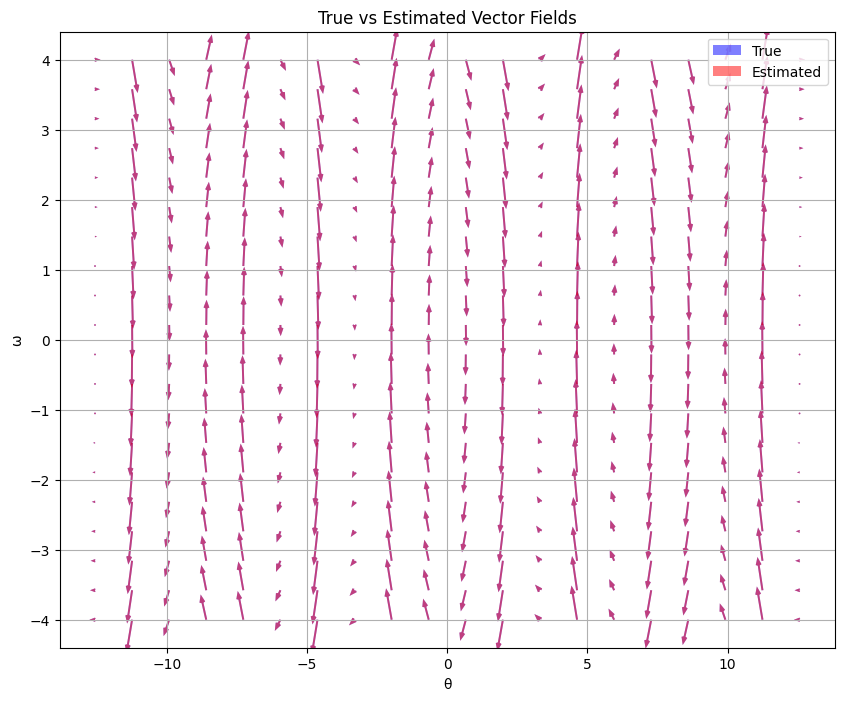

In [827]:
# Grid bounds
theta_lo, omega_lo = -4*np.pi, -4
theta_hi, omega_hi = 4*np.pi, 4

# Grid resolution
num_points = 20

# Create grid of (theta, omega)
theta_vals = np.linspace(theta_lo, theta_hi, num_points)
omega_vals = np.linspace(omega_lo, omega_hi, num_points)
Theta, Omega = np.meshgrid(theta_vals, omega_vals)  # shape (num_points, num_points)

# Flatten grid for vectorized computation
grid_points = np.stack([Theta.ravel(), Omega.ravel()], axis=-1)  # shape (N^2, 2)

us_null = np.zeros((grid_points.shape[0], pendulum.nu))
grid_points_dot = pendulum.dynamics(grid_points, us_null)

phi_grid_points = phi(grid_points)
phi_grid_points_dot = phi_grid_points @ Akoop.T

grid_points_dot_est = phi_grid_points_dot[:, :pendulum.nx]

# Plot
plt.figure(figsize=(10, 8))
plt.quiver(grid_points[:, 0], grid_points[:, 1],
           grid_points_dot[:, 0], grid_points_dot[:, 1],
           color='blue', alpha=0.5, label='True',
           angles='xy', scale_units='xy', scale=20,
           width=0.0025, headwidth=3, headlength=4)

plt.quiver(grid_points[:, 0], grid_points[:, 1],
           grid_points_dot_est[:, 0], grid_points_dot_est[:, 1],
           color='red', alpha=0.5, label='Estimated',
           angles='xy', scale_units='xy', scale=20,
           width=0.0025, headwidth=3, headlength=4)

plt.xlabel("θ")
plt.ylabel("ω")
plt.title("True vs Estimated Vector Fields")
plt.legend()
plt.grid(True)
plt.show()

In [828]:
def sinusoidal_smooth_controls(T, N=1, nu=1, num_freqs=10, freq_scale=1.0):
    t = np.linspace(0, 2 * np.pi, T)
    u_smooth = np.zeros((N, T, nu))
    
    for f in range(1, num_freqs + 1):
        phase = np.random.uniform(0, 2*np.pi, size=(N, nu))
        amp = np.random.randn(N, nu) / f**freq_scale
        u_smooth += amp[:, None, :] * np.sin(f * t[None, :, None] + phase[:, None, :])
    
    if N == 1:
        u_smooth = u_smooth[0]
    
    return t, u_smooth

def square_wave_controls(T, N=1, nu=1, period=50, amplitude=1.0, random_phase=True):
    t = np.arange(T)
    u = np.zeros((N, T, nu), dtype=float)

    # how many timesteps ON in each cycle
    on_time = int(np.round(0.5 * period))

    # for each batch & dimension, optionally pick a random phase offset
    if random_phase:
        phases = np.random.randint(0, period, size=(N, nu))
    else:
        phases = np.zeros((N, nu), dtype=int)

    for n in range(N):
        for i in range(nu):
            phase = phases[n, i]
            # compute time within cycle: (t + phase) mod period
            cycle_pos = (t + phase) % period
            # on when cycle_pos < on_time
            u[n, cycle_pos < on_time, i] = 1.0

    # drop batch axis if N == 1
    if N == 1:
        u = u[0]

    return t, amplitude * u

In [829]:
H = 120
dt = 0.02
t = dt * np.arange(0, H+1, 1)

theta0 = 2.5
omega0 = -1.0
# _, uhist = sinusoidal_smooth_controls(H, N=1, nu=pendulum.nu, num_freqs=10, freq_scale=0.2)
_, uhist = square_wave_controls(H, N=1, nu=pendulum.nu, period=30, amplitude=5.0, random_phase=False)
# uhist = np.zeros((H, nu)) #( np.sin(2 * np.pi * t[:-1]) * 10.0)[:, None]

x0 = np.array([theta0, omega0])
u0 = uhist[0]              # no torque

f0 = pendulum_dynamics(x0, u0)
A_linear = Jx(x0, u0)  # Jacobian w.r.t. x
B_linear = Ju(x0, u0)  # Jacobian w.r.t. u

linear_dynamics = lambda x, u : f0 + A_linear @ (x - x0) + B_linear @ (u - u0)

xhist = np.zeros((H + 1, 2))
xhist[0] = x0

zhist_koop = np.zeros((H + 1, nz))
zhist_koop[0] = phi(x0[None, :])

xhist_linear = np.zeros((H + 1, 2))
xhist_linear[0] = x0

def koopman_dynamics(z, u):
    Y = koopman_Y(z, u)
    return Wkoop @ Y

def koopman_dynamics2(z, u):
    x = z[:pendulum.nx]
    z_dot = Akoop @ z + phi_jac(x) @ B_nom @ u
    
    return z_dot

for i in range(0, H):
    xcurr = xhist[i]
    ucurr = uhist[i]
    
    xhist[i+1] = rk4_step(pendulum.dynamics, xcurr, ucurr, dt)

    # Compute the next state using RK4
    zcurr = zhist_koop[i]
    zhist_koop[i+1] = rk4_step(koopman_dynamics, zcurr, ucurr, dt)
    
    xcurr_linear = xhist_linear[i]
    xhist_linear[i+1] = rk4_step(linear_dynamics, xcurr_linear, ucurr, dt)

xhist_pred = zhist_koop[:, :pendulum.nx]

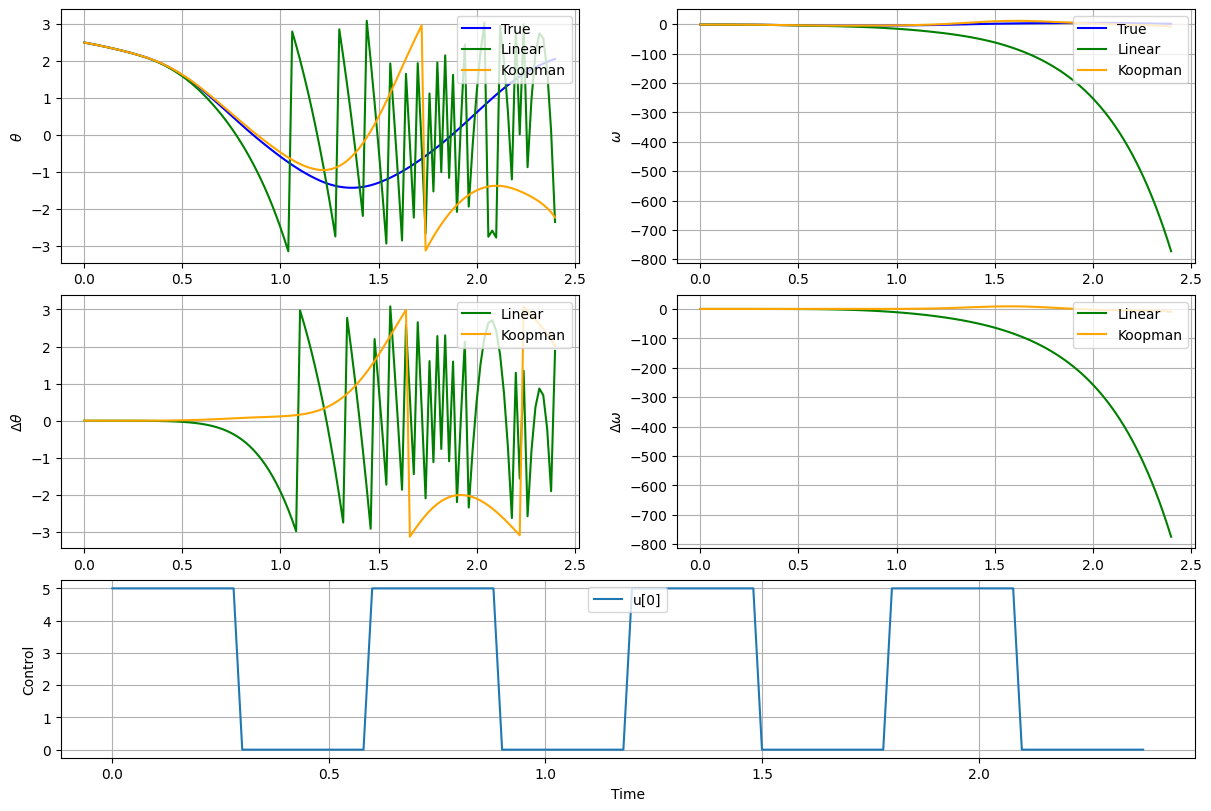

In [830]:
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs  = fig.add_gridspec(3, 2, height_ratios=[1, 1, 0.7])

# 1) Top row: θ and ω actual vs. models
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# 2) Middle row: θ‑error and ω‑error
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# 3) Bottom row: controls, spanning both columns
ax5 = fig.add_subplot(gs[2, :])

# data
c_true = 'blue'
c_lin  = 'green'
c_kp   = 'orange'

theta_true = wrap_mpi_pi(xhist[:, 0])
omega_true = xhist[:, 1]

theta_lin  = wrap_mpi_pi(xhist_linear[:, 0])
omega_lin  = xhist_linear[:, 1]

theta_kp   = wrap_mpi_pi(xhist_pred[:, 0])
omega_kp   = xhist_pred[:, 1]

theta_lin_err = angdiff(theta_lin, theta_true)
theta_kp_err  = angdiff(theta_kp, theta_true)

omega_lin_err = omega_lin - omega_true
omega_kp_err  = omega_kp  - omega_true

# θ over time
ax1.plot(t, theta_true, label='True', color=c_true)
ax1.plot(t, theta_lin,  label='Linear', color=c_lin)
ax1.plot(t, theta_kp,   label='Koopman', color=c_kp)
ax1.set_ylabel(r'$\theta$')
ax1.legend(loc='upper right')
ax1.grid(True)

# ω over time
ax2.plot(t, omega_true, label='True', color=c_true)
ax2.plot(t, omega_lin,  label='Linear', color=c_lin)
ax2.plot(t, omega_kp,   label='Koopman', color=c_kp)
ax2.set_ylabel(r'$\omega$')
ax2.legend(loc='upper right')
ax2.grid(True)

# θ error
ax3.plot(t, theta_lin_err, label='Linear', color=c_lin)
ax3.plot(t, theta_kp_err, label='Koopman', color=c_kp)
ax3.set_ylabel(r'$\Delta\theta$')
ax3.legend(loc='upper right')
ax3.grid(True)

# ω error
ax4.plot(t, omega_lin_err, label='Linear', color=c_lin)
ax4.plot(t, omega_kp_err, label='Koopman', color=c_kp)
ax4.set_ylabel(r'$\Delta\omega$')
ax4.legend(loc='upper right')
ax4.grid(True)

# Controls
for i in range(uhist.shape[1]):
    ax5.plot(t[:-1], uhist[:, i], label=f'u[{i}]')
ax5.set_ylabel('Control')
ax5.set_xlabel('Time')
ax5.legend(loc='upper center', ncol=min(4, uhist.shape[-1]))
ax5.grid(True)

plt.show()